In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GadiClient import GadiClient
from sklearn.cluster import KMeans as kmeans
from merge_data import get_env_clusters
from era5_spatial_cluster import transform_era5, era5_clustering
from merge_data_barpa import load_barpac_m_wg, load_barpac_m_lightning

import dask
dask.config.set({"array.slicing.split_large_chunks":True})

In [2]:
GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39701,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:39959,Total threads: 1
Dashboard: /proxy/38649/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:32973,


In [3]:
#This code is aimed towards getting a daily, domain maximum time series of BARPAC data, using all spatial points

fid = "0_20050101_20050105"

In [4]:
#Load 5 days of ACCESS-forced sample data (10-minute wind gusts over whole domain)

#f = xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/cmip5/ACCESS1-0/historical/r1i1p1/20041103T0000Z/20050122T0000Z/pp26/*")
f,_,_=load_barpac_m_wg(fid,"cmip5","ACCESS1-0","historical","r1i1p1")


In [5]:
#Now calculate the wind gust ratio.
#Note assertion/assumption is that data is 10-minute, because xarray rolling can't handle time-aware windows

assert f.time_coverage_resolution == 'PT9M59S', "CHECK TIME OUTPUT FREQUENCY, IS NOT EQUAL TO 10 MINS, SO ROLLING WINDOW MIGHT NEED TO BE CHANGED"

f["wgr"] = f.max_wndgust10m / (f.max_wndgust10m.rolling(time=24, min_periods=6, center=True).mean()).persist()

In [6]:
#Get the environmental information from BARPA-R. This includes variables for clustering
env = xr.open_mfdataset("/scratch/eg3/ab4502/barpa_access_"+pd.to_datetime(fid.split("_")[1]).strftime("%Y%m%d")+"*.nc",
                        chunks={"time":-1})[["lr13","qmean01","Umean06","s06","bdsd"]]

#Slice to times where we have wind gust output
f_times = pd.to_datetime(f.time.values).round("6H")
env = env.sel(time=slice(f_times[0],f_times[-1]))

#Resample all variables (clustering variables and BDSD) to a 100 x 100 rolling max
dx_km = 12
radius_km = 50
radius_pixels = int(np.floor(radius_km*2 / dx_km))
env = env.rolling(dim={"lat":radius_pixels, "lat":radius_pixels},center=True,min_periods=radius_pixels/2).max().persist()

In [7]:
#Get the environmental clustering model based on Umean, lr13, qmean, and s06
cluster_mod, cluster_input = get_env_clusters()

#Perform the clustering on the BARPA-R data
s06, qmean01, lr13, Umean06 = transform_era5(env, cluster_mod, cluster_input)
cluster = era5_clustering(s06.persist(), qmean01.persist(), lr13.persist(), Umean06.persist(), env, cluster_mod).persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 13.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [8]:
#Spatially interpolate the BARPA-R data to the BARPAC grid
cluster["bdsd"] = cluster["bdsd"].interp({"lat":f.latitude,"lon":f.longitude},method="linear").persist()
cluster["cluster"] = cluster["cluster"].interp({"lat":f.latitude,"lon":f.longitude},method="nearest").persist()

#Select 10-minute times from the environmental data (rounding to most recent 6-hourly time step)
cluster = cluster.sel(time=f_times)
cluster["time"] = f["time"]

#Add environmental data to the gust dataset
f["bdsd"] = cluster["bdsd"]
f["cluster"] = cluster["cluster"]

In [9]:
#Now calculate the daily maximum gust, and keep the wgr + environmental info for those gusts.
#Best I could do is a loop for now. Think it should be efficient enough when qsubbed

dmax_wgr = []
dmax_bdsd = []
dmax_cluster = []
times = []
for name, group in f.groupby("time.date"):
    times.append(name)
    #group = group.chunk(chunks={"time":6})
    dmax_wgr.append(xr.where(group.max_wndgust10m == group.max_wndgust10m.max("time"),group.wgr,np.nan).max("time"))
    dmax_bdsd.append(xr.where(group.max_wndgust10m == group.max_wndgust10m.max("time"),group.bdsd,np.nan).max("time"))
    dmax_cluster.append(xr.where(group.max_wndgust10m == group.max_wndgust10m.max("time"),group.cluster,np.nan).max("time"))    
    
dmax_wgr = xr.concat(dmax_wgr,"date").persist()
dmax_wgr["date"] = times

dmax_bdsd = xr.concat(dmax_bdsd,"date").persist()
dmax_bdsd["date"] = times

dmax_cluster = xr.concat(dmax_cluster,"date").persist()
dmax_cluster["date"] = times

#Resample gusts to daily max as usual
dmax_gust = f["max_wndgust10m"].groupby("time.date").max().persist()

In [10]:
#Load the daily max lightning field
#l = xr.open_mfdataset("/scratch/tp28/cst565/ESCI/BARPAC-M_km2p2/cmip5/ACCESS1-0/historical/r1i1p1/20041103T0000Z/20050122T0000Z/pp0/n_lightning_fl-pp0-BARPAC-M_km2p2-20050122T0000Z.nc")
l,_,_=load_barpac_m_lightning(fid,"cmip5","ACCESS1-0","historical","r1i1p1")

l["time"] = pd.to_datetime(l.time.values).floor("D")
l = l.rename({"time":"date"})

In [11]:
#Combine into one Dataset
ds=xr.Dataset({"wgr_dmax":dmax_wgr,"gust_dmax":dmax_gust,"lightning":l["n_lightning_fl"],"bdsd":dmax_bdsd,"cluster":dmax_cluster})

#Create a binary lightning field, and dialate this field using a 50 km radius

# def dialation(X):
#     def func(x):
#         return [skm.binary_dilation(x[i,:,:], disk) for i in np.arange(x.shape[0])]
#     return xr.apply_ufunc(func, X, dask="allowed")

# disk = skm.disk(radius_pixels)

# ds["lightning50"] = dialation( (ds.lightning >= 1) ) * 1

#Could also use rolling max for lightning, as this is more consistent with what we did for station locations.

#Define the maximum over a 100*100 km grid box
dx_km = 2.2
radius_km = 50
radius_pixels = int(np.floor(radius_km * 2 / dx_km))


ds["lightning50"] = ds.lightning.rolling(dim={"latitude":radius_pixels, "longitude":radius_pixels},center=True,min_periods=radius_pixels/2).sum()
ds = ds.drop(["height","realization","forecast_period","forecast_reference_time"]).drop_indexes(["date","latitude","longitude"]).persist()

In [12]:
#Mask ocean
barpa_lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/lnd_mask-BARPAC-M_km2p2.nc")
ds = xr.where(barpa_lsm.lnd_mask==1,ds,np.nan)


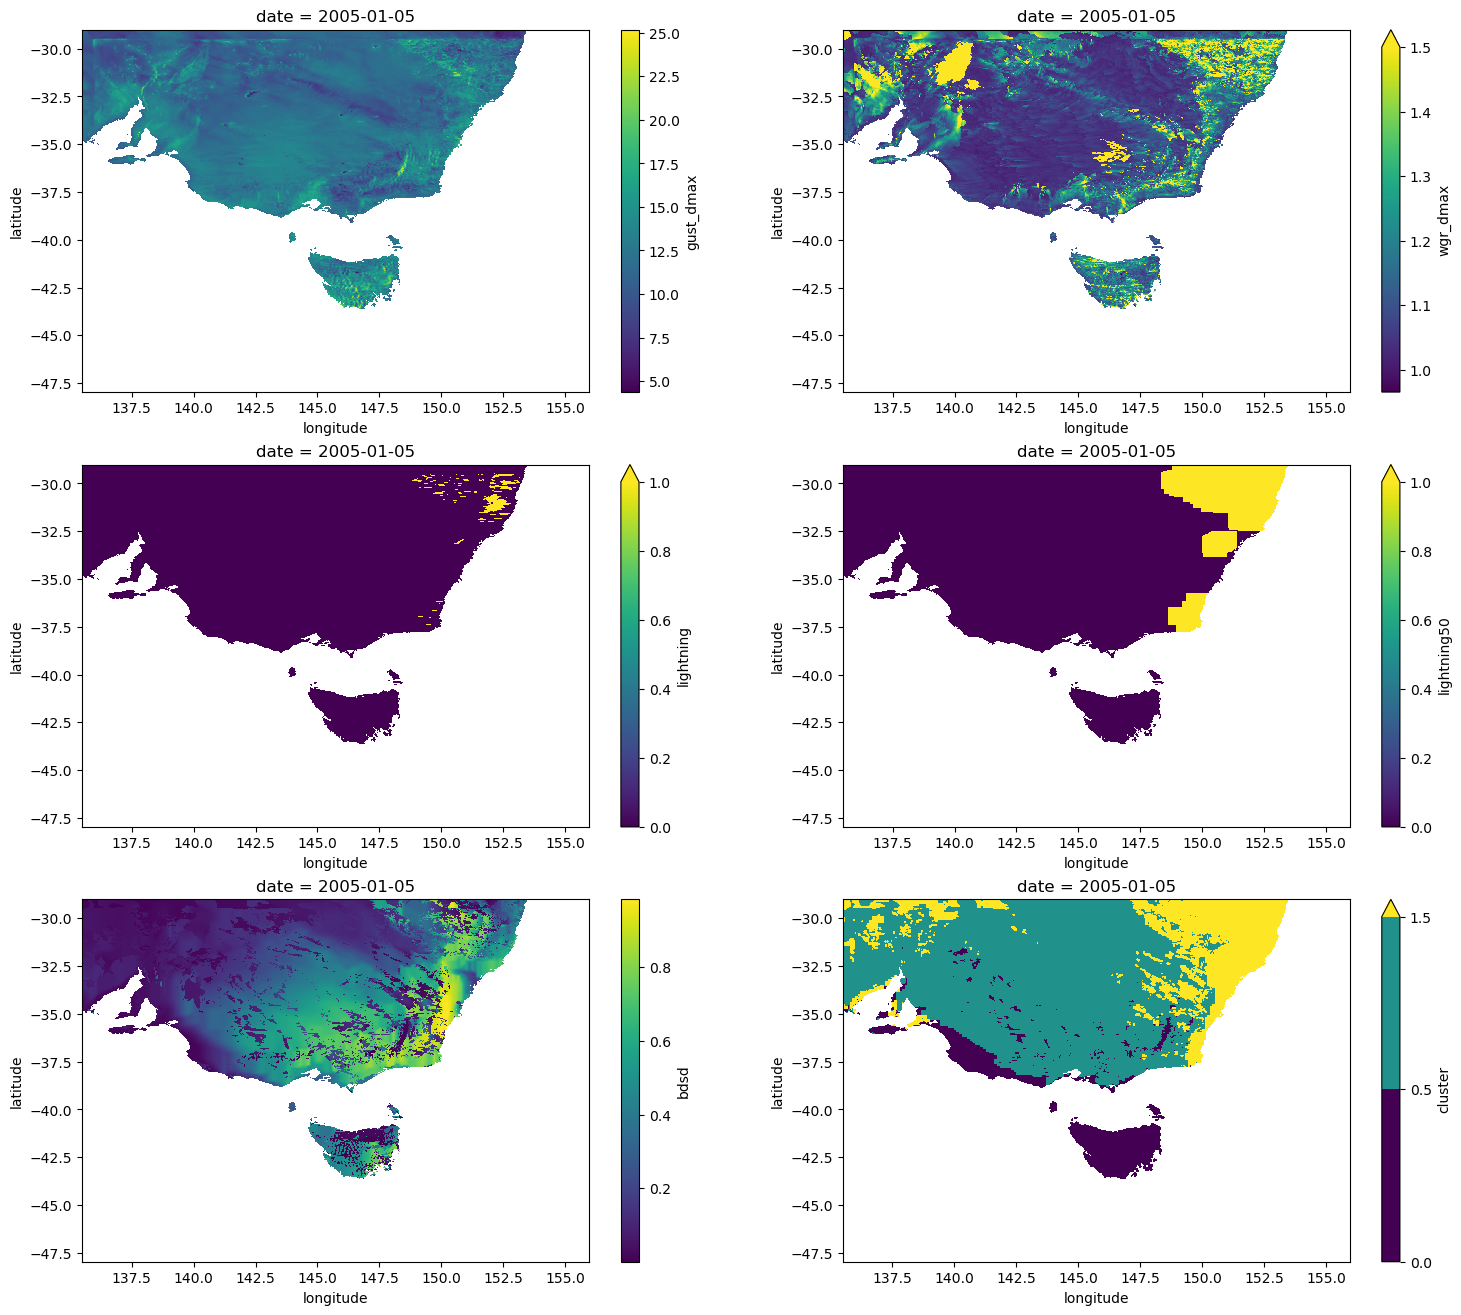

In [13]:
idate=4

plt.figure(figsize=[18,16])
plt.subplot(3,2,1)
ds.gust_dmax.isel(date=idate).plot()

plt.subplot(3,2,2)
ds.wgr_dmax.isel(date=idate).plot(vmax=1.5)

plt.subplot(3,2,3)
ds.lightning.isel(date=idate).plot(vmax=1)

plt.subplot(3,2,4)
ds.lightning50.isel(date=idate).plot(vmax=1)

plt.subplot(3,2,5)
ds.bdsd.isel(date=idate).plot()

plt.subplot(3,2,6)
xr.plot.contourf(ds.cluster.isel(date=idate),levels=[0,0.5,1.5],extend="max")

In [14]:
#Get the spatial locations of the domain maximum gust
argmax = ds.gust_dmax.argmax(["latitude","longitude"])

#Get the daily domain max gust and output as a pandas dataframe
ddmax = ds.isel(latitude=argmax["latitude"].expand_dims("points").compute(), 
                  longitude=argmax["longitude"].expand_dims("points").compute())
ddmax_df = ddmax.to_dataframe()
ddmax_df["date"] = ddmax["date"]
ddmax_df

wgr_dmax  gust_dmax  lightning      bdsd  cluster  lightning50  \
points date                                                                   
0      0     2.331101  37.871094        0.0  0.848204      1.0          0.0   
       1     1.142501  32.380859        0.0  0.018007      0.0          0.0   
       2     1.060686  30.158203        0.0  0.886122      0.0          0.0   
       3     1.698812  27.155273        0.0  0.703607      0.0          0.0   
       4     1.178855  25.176758        0.0  0.002124      0.0          0.0   

              latitude   longitude        date  
points date                                     
0      0    -34.820000  143.559998  2005-01-01  
       1    -41.619999  146.360001  2005-01-02  
       2    -41.639999  146.399994  2005-01-03  
       3    -42.879997  147.740005  2005-01-04  
       4    -42.599998  146.580002  2005-01-05

In [15]:
#Do the same but for convective gusts
argmax_conv = ds.gust_dmax.where(ds.lightning50 >= 1, -999).argmax(["latitude","longitude"],skipna=True)
ddmax_conv = ds.isel(latitude=argmax_conv["latitude"].expand_dims("points").compute(), 
                   longitude=argmax_conv["longitude"].expand_dims("points").compute())
ddmax_conv_df = ddmax_conv.to_dataframe()
ddmax_conv_df["date"] = ddmax_conv["date"]
ddmax_conv_df

wgr_dmax  gust_dmax  lightning      bdsd  cluster  lightning50  \
points date                                                                   
0      0     2.210022  36.988281        0.0  0.898685      1.0         28.0   
       1     1.152286  19.697266        0.0  0.005727      0.0          8.0   
       2     1.118460  28.789062        0.0  0.880480      0.0          1.0   
       3     2.211349  21.519531        0.0  0.218873      2.0         23.0   
       4     2.340893  23.074219        0.0  0.681335      1.0         73.0   

              latitude   longitude        date  
points date                                     
0      0    -35.619999  144.899994  2005-01-01  
       1    -40.439999  144.839996  2005-01-02  
       2    -41.680000  146.460007  2005-01-03  
       3    -29.719999  149.720001  2005-01-04  
       4    -31.240000  150.559998  2005-01-05

In [16]:
#Do the same but for convective gusts where wgr >= 1.5

argmax_conv_wgr = ds.gust_dmax.where((ds.lightning50 >= 1) & (ds.wgr_dmax >= 1.5), -999).argmax(["latitude","longitude"],skipna=True)
ddmax_conv_wgr = ds.isel(latitude=argmax_conv_wgr["latitude"].expand_dims("points").compute(), 
                  longitude=argmax_conv_wgr["longitude"].expand_dims("points").compute())
ddmax_conv_wgr_df = ddmax_conv_wgr.to_dataframe()
ddmax_conv_wgr_df["date"] = ddmax_conv_wgr["date"]
ddmax_conv_wgr_df

wgr_dmax  gust_dmax  lightning      bdsd  cluster  lightning50  \
points date                                                                   
0      0     2.210022  36.988281        0.0  0.898685      1.0         28.0   
       1          NaN        NaN        NaN       NaN      NaN          NaN   
       2     1.797446  27.083984        0.0  0.755871      0.0        174.0   
       3     2.211349  21.519531        0.0  0.218873      2.0         23.0   
       4     2.340893  23.074219        0.0  0.681335      1.0         73.0   

              latitude   longitude        date  
points date                                     
0      0    -35.619999  144.899994  2005-01-01  
       1    -47.959999  135.500000  2005-01-02  
       2    -41.239998  144.699997  2005-01-03  
       3    -29.719999  149.720001  2005-01-04  
       4    -31.240000  150.559998  2005-01-05

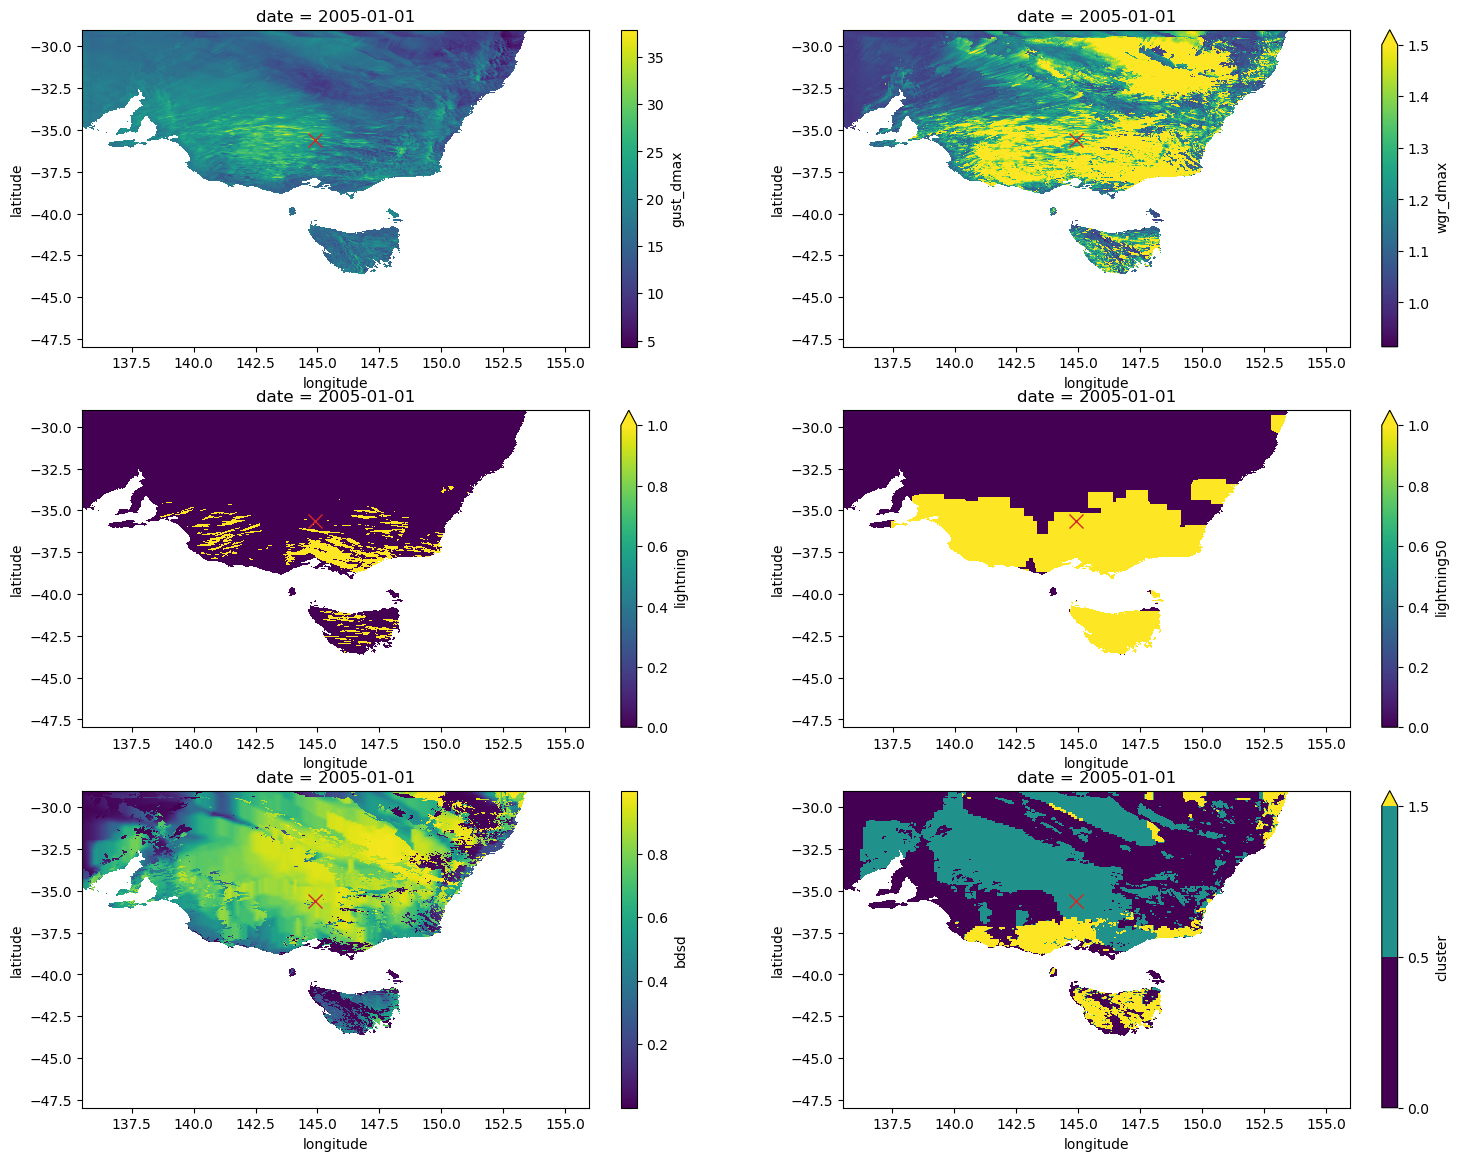

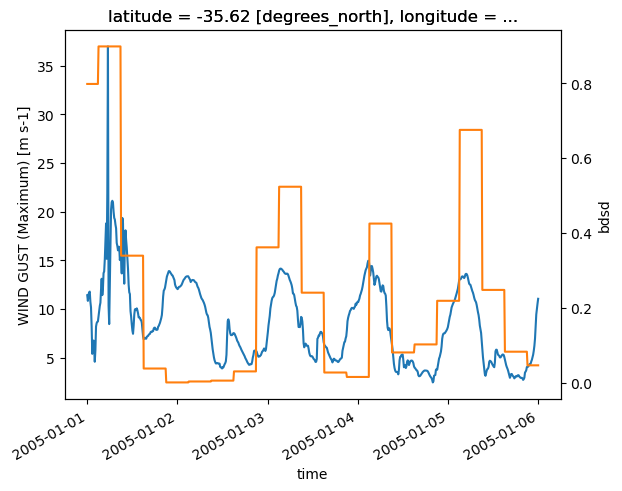

In [17]:
idate = 0
lat, lon = ddmax_conv_wgr.to_dataframe().loc[0,idate][["latitude","longitude"]].values

plt.figure(figsize=[18,14])
plt.subplot(3,2,1)
ds.gust_dmax.isel(date=idate).plot()
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(3,2,2)
ds.wgr_dmax.isel(date=idate).plot(vmax=1.5)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(3,2,3)
ds.lightning.isel(date=idate).plot(vmax=1)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(3,2,4)
ds.lightning50.isel(date=idate).plot(vmax=1)
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(3,2,5)
ds.bdsd.isel(date=idate).plot()
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.subplot(3,2,6)
xr.plot.contourf(ds.cluster.isel(date=idate),levels=[0,0.5,1.5],extend="max")
plt.plot(lon,lat,marker="x",ms=10,color="tab:red",mew=1)

plt.figure()
f.max_wndgust10m.sel(latitude=lat,longitude=lon).plot()
ax=plt.gca().twinx()
f.bdsd.sel(latitude=lat,longitude=lon).plot(ax=ax,color="tab:orange")